<a href="https://colab.research.google.com/github/Gaurav1401/Deep-Learning/blob/main/Practice/CNN/TMLC/102_Category_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading and Unzipping the Files**

In [1]:
# !wget "https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz"

--2021-10-29 11:47:13--  https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.201.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.201.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345236087 (329M) [application/x-tar]
Saving to: ‘oxford-102-flowers.tgz.1’

oxford-102-flowers. 100%[===================>] 329.24M  35.8MB/s    in 10s     

2021-10-29 11:47:23 (32.8 MB/s) - ‘oxford-102-flowers.tgz.1’ saved [345236087/345236087]



In [2]:
# Unzipping the file
# !tar -xzvf "/content/oxford-102-flowers.tgz"

# **Checking the folder content**

In [3]:
!ls oxford-102-flowers # list of files in the folder

jpg  test.txt  train.txt  valid.txt


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib # to access files inside folders eaasily
import os
from tqdm import tqdm # for graph like progress bars

In [5]:
len(os.listdir("/content/oxford-102-flowers/jpg")) # checking number of image files in the jpg folder

8189

In [6]:
path = pathlib.Path("oxford-102-flowers")
all_paths = path.glob("*/*.jpg")
all_paths

<generator object Path.glob at 0x7fddf1b8b150>

In [7]:
all_paths = list(all_paths)
all_paths[:5]

[PosixPath('oxford-102-flowers/jpg/image_07212.jpg'),
 PosixPath('oxford-102-flowers/jpg/image_06933.jpg'),
 PosixPath('oxford-102-flowers/jpg/image_06594.jpg'),
 PosixPath('oxford-102-flowers/jpg/image_01455.jpg'),
 PosixPath('oxford-102-flowers/jpg/image_02769.jpg')]

In [8]:
all_paths = list(map(lambda x : str(x), all_paths))
all_paths[:5]

['oxford-102-flowers/jpg/image_07212.jpg',
 'oxford-102-flowers/jpg/image_06933.jpg',
 'oxford-102-flowers/jpg/image_06594.jpg',
 'oxford-102-flowers/jpg/image_01455.jpg',
 'oxford-102-flowers/jpg/image_02769.jpg']

**Reading the text files**

In [9]:
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(p[0])
            y.append(int(p[1]))

    return x, y

In [10]:
X_train, y_train = Read_Two_Column_File('/content/oxford-102-flowers/train.txt')
X_valid, y_valid = Read_Two_Column_File("/content/oxford-102-flowers/valid.txt")

In [11]:
X_train[:5]

['jpg/image_03860.jpg',
 'jpg/image_06092.jpg',
 'jpg/image_02400.jpg',
 'jpg/image_02852.jpg',
 'jpg/image_07710.jpg']

In [12]:
def complete_path(image_path):
  return "oxford-102-flowers/" + image_path

**Making the image path complete in the list**

In [13]:
X_train = list(map(complete_path, X_train))
X_valid = list(map(complete_path, X_valid))

In [14]:
X_train[:5]

['oxford-102-flowers/jpg/image_03860.jpg',
 'oxford-102-flowers/jpg/image_06092.jpg',
 'oxford-102-flowers/jpg/image_02400.jpg',
 'oxford-102-flowers/jpg/image_02852.jpg',
 'oxford-102-flowers/jpg/image_07710.jpg']

In [15]:
y_train[:5]

[16, 13, 42, 55, 96]

### **One hot encoding the target variables**

In [16]:
train_image_labels = tf.keras.utils.to_categorical(y_train)

train_image_labels[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
valid_image_labels = tf.keras.utils.to_categorical(y_valid)

valid_image_labels[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [19]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 224 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [20]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [21]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(X_train , train_image_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 467 ms, sys: 7.11 ms, total: 474 ms
Wall time: 482 ms
(32, 224, 224, 3)
(32, 102)


In [22]:
%time val_dataset = get_dataset(X_valid , valid_image_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 22.9 ms, sys: 961 µs, total: 23.9 ms
Wall time: 26.9 ms
(32, 224, 224, 3)
(32, 102)


# **Hyperparameter Tuning using Keras Tuner**

In [23]:
# !pip install -q -U keras-tuner

In [24]:
from keras_tuner.tuners import RandomSearch

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization , GlobalMaxPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [26]:
def create_model(hyperparam):
   model = Sequential()
   model.add(Conv2D(
                    filters=hyperparam.Int('convolution_1',min_value=32, max_value=128, step=16), 
                      kernel_size=hyperparam.Choice('convolution_1', values = [3,6]),
                    padding = 'same',
                    activation='relu',input_shape=(224 , 224 , 3)
                    ))
   model.add(Conv2D(
                    filters=hyperparam.Int('convolution_2', min_value=64, max_value=128, step=16),
                    kernel_size=hyperparam.Choice('convolution_2', values = [3,6]),
                    padding = 'valid',
                    activation='relu'
                    ))
   model.add(Conv2D(
                  filters=hyperparam.Int('convolution_3', min_value=64, max_value=128, step=16),
                  kernel_size=hyperparam.Choice('convolution_3', values = [3,6]),
                  padding = 'valid',
                  activation='relu'
                   ))
   model.add(Flatten())
   model.add(Dense(units = 102))
   model.add(Activation("softmax"))
   model.compile(optimizer=optimizers.Adam(hyperparam.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
   return model

In [27]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='CNN_Flower')

In [ ]:
tuner.search(train_dataset,
             epochs=5,
             validation_data= val_dataset,
             steps_per_epoch=5)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
convolution_1     |112               |?                 
convolution_2     |112               |?                 
convolution_3     |80                |?                 
learning_rate     |0.001             |?                 

Epoch 1/5


## **Don't know why but Hyperparameter tuning did not work :(, taking infinite amount of time**

In [ ]:
# Simple CNN model

# Model part 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization , GlobalMaxPool2D
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

# Block 1 
model.add(Conv2D(input_shape=(224 , 224 , 3),  padding='same',filters=32, kernel_size=(7, 7)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(filters=64,  padding='valid', kernel_size=(5, 5)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3 
model.add(Conv2D(filters=128, padding='valid', kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# Block 4 
model.add(Conv2D(filters=256, padding='valid', kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256 , kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPool2D())

model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=102))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      4736      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      51264     
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 64)     

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    epochs=20,
    validation_data=val_dataset,
    validation_steps = len(X_valid)//BATCH_SIZE,
    callbacks = early_stop
)

Epoch 1/20
31/31 [==============================] - 21s 453ms/step - loss: 5.9209 - accuracy: 0.0131 - val_loss: 13.9237 - val_accuracy: 0.0151
Epoch 2/20
31/31 [==============================] - 18s 526ms/step - loss: 4.3754 - accuracy: 0.0263 - val_loss: 5.6002 - val_accuracy: 0.0302
Epoch 3/20
31/31 [==============================] - 16s 527ms/step - loss: 4.1137 - accuracy: 0.0759 - val_loss: 4.5445 - val_accuracy: 0.0393
Epoch 4/20
31/31 [==============================] - 16s 517ms/step - loss: 3.8289 - accuracy: 0.0941 - val_loss: 3.8962 - val_accuracy: 0.0837
Epoch 5/20
31/31 [==============================] - 16s 520ms/step - loss: 3.6530 - accuracy: 0.1336 - val_loss: 3.5784 - val_accuracy: 0.1653
Epoch 6/20
31/31 [==============================] - 16s 529ms/step - loss: 3.4300 - accuracy: 0.1498 - val_loss: 3.5731 - val_accuracy: 0.1391
Epoch 7/20
31/31 [==============================] - 16s 518ms/step - loss: 3.2832 - accuracy: 0.1771 - val_loss: 3.7947 - val_accuracy: 0.100

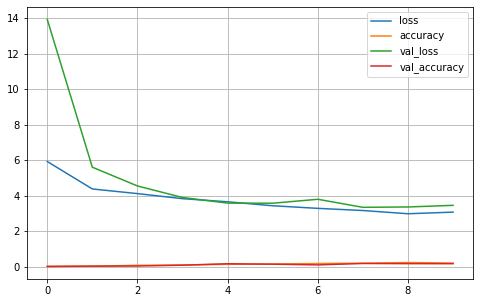

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.show()

In [ ]:
# Model Evaluation
loss, acc = model.evaluate(val_dataset, steps=50)

print(" Testing Acc : " , acc)
print(" Testing Loss : " , loss)

50/50 [==============================] - 7s 103ms/step - loss: 3.4644 - accuracy: 0.1635
 Testing Acc :  0.16353383660316467
 Testing Loss :  3.4644358158111572


# **Transfer Learning using VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
conv_base = VGG16(weights = 'imagenet', 
                  include_top = False,
                  input_shape = (224, 224, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(204, activation='relu'))
model1.add(Dense(102, activation = 'softmax'))

In [ ]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 204)               5118156   
_________________________________________________________________
dense_3 (Dense)              (None, 102)               20910     
Total params: 19,853,754
Trainable params: 19,853,754
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv_base.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model1.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(learning_rate = 2e-5), metrics = ['accuracy'])

In [ ]:
history = model1.fit(
                      train_dataset,
                      steps_per_epoch=len(X_train)//BATCH_SIZE,
                      epochs=20,
                      validation_data=val_dataset,
                      validation_steps = len(X_valid)//BATCH_SIZE,
                      callbacks = early_stop
)

Epoch 1/20
31/31 [==============================] - 36s 750ms/step - loss: 17.5393 - accuracy: 0.0111 - val_loss: 16.2322 - val_accuracy: 0.0181
Epoch 2/20
31/31 [==============================] - 34s 832ms/step - loss: 11.4507 - accuracy: 0.0213 - val_loss: 11.5249 - val_accuracy: 0.0272
Epoch 3/20
31/31 [==============================] - 25s 825ms/step - loss: 7.9895 - accuracy: 0.0466 - val_loss: 8.6657 - val_accuracy: 0.0202
Epoch 4/20
31/31 [==============================] - 25s 830ms/step - loss: 6.2935 - accuracy: 0.0405 - val_loss: 6.9611 - val_accuracy: 0.0212
Epoch 5/20
31/31 [==============================] - 25s 822ms/step - loss: 5.4225 - accuracy: 0.0405 - val_loss: 6.0723 - val_accuracy: 0.0262
Epoch 6/20
31/31 [==============================] - 25s 820ms/step - loss: 4.8820 - accuracy: 0.0617 - val_loss: 5.6057 - val_accuracy: 0.0252
Epoch 7/20
31/31 [==============================] - 25s 822ms/step - loss: 4.5835 - accuracy: 0.0810 - val_loss: 5.4140 - val_accuracy: 0.

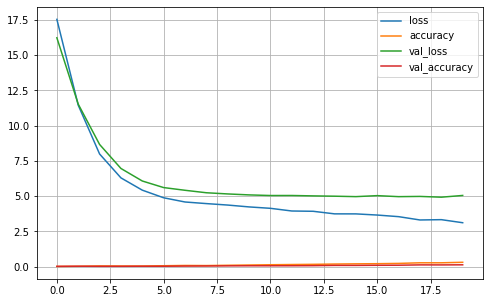

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.show()